<a href="https://colab.research.google.com/github/wenjunsun/Covid-19-analysis-with-uw-ubicomp/blob/master/2020-12/continuous_treatment_effect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd drive/MyDrive/covid/PSM/data

/content/drive/MyDrive/covid/PSM/data


In [ ]:
ls

agg_social_dist_2.csv
agg_social_dist.csv
avg_google_mobility_up_to_6_1.csv
avg_google_mobility_up_to_6_1_weekdays.csv
county_data_with_reduced_covariates_with_SIP.csv
data_with_policy_scores.csv
final_data_google_and_safe_graph_up_to_6_1.csv
final_data_google_and_safe_graph_up_to_6_1_weekdays.csv
final_policy_scores.csv
google_mobility.csv
policy_scores.csv
social_dist_aggregated_on_county.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load R + R packages

In [ ]:
%load_ext rpy2.ipython
# For (automatic) translation of Pandas objects to R
from rpy2.robjects import pandas2ri
pandas2ri.activate()

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [ ]:
%%R
install.packages('stats')
install.packages('survey')

In [ ]:
%%R
library('stats')
library('survey')

# load data

In [ ]:
data = pd.read_csv('data_with_policy_scores.csv')

In [ ]:
data

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White,GovernmentResponseIndex
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,69.134839
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,69.134839
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,69.134839
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,69.134839
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,69.134839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,56.0,WY,Wyoming,Sweetwater County,56037.0,-0.018485,0,73315.0,10.9,43051,-0.535382,26.2,12.1,1.0,1.1,16.1,79.3,66.658226
2991,56.0,WY,Wyoming,Teton County,56039.0,0.075183,1,99087.0,46.4,23081,0.278663,18.4,15.4,1.4,0.6,14.9,81.5,66.658226
2992,56.0,WY,Wyoming,Uinta County,56041.0,0.010157,0,63401.0,43.1,20299,-0.614926,28.8,14.1,0.5,0.7,9.2,87.4,66.658226
2993,56.0,WY,Wyoming,Washakie County,56043.0,-0.007825,0,55190.0,36.0,7885,-0.640377,22.7,21.7,0.8,0.5,14.1,82.4,66.658226


Text(0, 0.5, '# of counties')

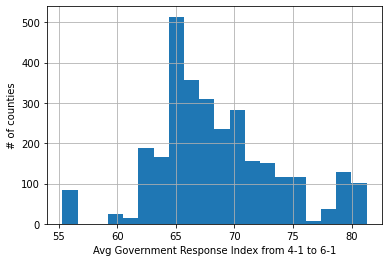

In [ ]:
# let's see the distribution of government response scores
data['GovernmentResponseIndex'].hist(bins = 20)
plt.xlabel('Avg Government Response Index from 4-1 to 6-1')
plt.ylabel('# of counties')

In [ ]:
data = data.dropna()

# 1. calculate genearlized propensity score of each row

does covariate of a county really predicts its dosage? covariate is property of a county but dosage is at the state level.

In [ ]:
%%R -i data
head(data)

  state state_code State.Name      cnamelong county_code diff_in_perc_at_home
0     1         AL    Alabama Autauga County        1001          0.050678282
1     1         AL    Alabama Baldwin County        1003          0.050311979
2     1         AL    Alabama Barbour County        1005          0.007036924
3     1         AL    Alabama    Bibb County        1007          0.011808926
4     1         AL    Alabama  Blount County        1009          0.038890321
5     1         AL    Alabama Bullock County        1011         -0.009576347
  SIP. Median.Household.Income X..Rural Population_y political_diff
0    1                   59338     42.0        55601    -0.49478934
1    1                   57588     42.3       218022    -0.57786162
2    1                   34382     67.8        24881    -0.05611165
3    1                   46064     68.4        22400    -0.55544124
4    1                   50412     90.0        57840    -0.81381973
5    1                   29267     51.4       

In [ ]:
%%R
dosage_formula <- formula('GovernmentResponseIndex~Median.Household.Income+X..Rural+Population_y+political_diff+X..less.than.18.years.of.age+X..65.and.over+X..Asian+X..Black+X..Hispanic+X..Non.Hispanic.White')

In [ ]:
%%R
# linear regression of dosage based on covariates
dosage_model <- lm(formula = dosage_formula, data = data)

In [ ]:
%%R
# calculate generalized propensity score of each row based
# off our linear model
data$GPS = dnorm(data$GovernmentResponseIndex, mean = dosage_model$fitted,
                 sd = sd(data$GovernmentResponseIndex)) 

In [ ]:
%%R
head(data)

  state state_code State.Name      cnamelong county_code diff_in_perc_at_home
0     1         AL    Alabama Autauga County        1001          0.050678282
1     1         AL    Alabama Baldwin County        1003          0.050311979
2     1         AL    Alabama Barbour County        1005          0.007036924
3     1         AL    Alabama    Bibb County        1007          0.011808926
4     1         AL    Alabama  Blount County        1009          0.038890321
5     1         AL    Alabama Bullock County        1011         -0.009576347
  SIP. Median.Household.Income X..Rural Population_y political_diff
0    1                   59338     42.0        55601    -0.49478934
1    1                   57588     42.3       218022    -0.57786162
2    1                   34382     67.8        24881    -0.05611165
3    1                   46064     68.4        22400    -0.55544124
4    1                   50412     90.0        57840    -0.81381973
5    1                   29267     51.4       

# 2. check covaraite balance

 - TODO later

In [ ]:
%%R
balanceTable <- data.frame()
balanceFormula <- paste('GovernmentResponseIndex~GPS+', 'Population_y', sep = '')
maxEff <- max(abs(coef(lm(balanceFormula,data))[-(1:5)])) 

In [ ]:
%%R
maxEff

[1] -Inf


# 3. model outcome in terms of treatment dosage + GPS

In [ ]:
%%R
designAN <- svydesign(id=~1,weights=~1,data =data)
modelOutcome <- svyglm(formula = 'diff_in_perc_at_home~GovernmentResponseIndex+I(GovernmentResponseIndex^2) + GPS + I(GPS^2) + GovernmentResponseIndex:GPS', design = designAN) 

# 4. plot dosage response function

In [ ]:
%%R
all.effects <- data.frame()
for (dose in quantile(data$GovernmentResponseIndex, probs = seq(0.00, 1, 0.1)) ) {
    effects <- predict(modelOutcome, type = 'response', vcov = T,
                       newdata = data.frame(GovernmentResponseIndex=dose, GPS = data$GPS))
    effect <- svycontrast(effects, rep(1/nrow(data), nrow(data)) )
    all.effects <- rbind(all.effects, effect)
} 

In [ ]:
%%R
all.effects

   X0.00996308829104974
1           0.009963088
2           0.013795090
3           0.018672620
4           0.020012583
5           0.022561233
6           0.025826412
7           0.030846820
8           0.035098176
9           0.046782189
10          0.056579258
11          0.096360795


In [ ]:
%%R
doseResponses <- data.frame(percentile = seq(0, 100, 10),
                            GovernmentResponseIndex = quantile(data$GovernmentResponseIndex,
                                                               probs = seq(0.00, 1, 0.1)),
                            all.effects )
# names(doseResponses)[4] <- "mean_diff_perc_stay_at_home"
# doseResponses$lowerCL <- with(doseResponses, mean_diff_perc_stay_at_home - 1.96*SE)
# doseResponses$upperCL <- with(doseResponses, mean_diff_perc_stay_at_home + 1.96*SE)

In [ ]:
%%R
doseResponses

     percentile GovernmentResponseIndex X0.00996308829104974
0%            0                55.30871          0.009963088
10%          10                62.55806          0.013795090
20%          20                65.02290          0.018672620
30%          30                65.57452          0.020012583
40%          40                66.53452          0.022561233
50%          50                67.63661          0.025826412
60%          60                69.13484          0.030846820
70%          70                70.27032          0.035098176
80%          80                72.97645          0.046782189
90%          90                74.93065          0.056579258
100%        100                81.29097          0.096360795
